
<br>
Example usage of DMF fMRI simulator.<br>
Pedro Mediano, June 2020<br>


In [1]:
import fastdyn_fic_dmf as dmf
from scipy.signal import butter, lfilter
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
params = dmf.default_params()

In [2]:
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd

Run simulation for a given nb of steps (milliseconds)

In [4]:
nb_steps = 1000000
C = params['C']
params['lrj'] = 8
params['taoj'] = 33000
params['G'] = 9
params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
N = C.shape[0]
tracemalloc.start()
rates, rates_inh, bold, fic_t = dmf.run(params, nb_steps,return_rate=True, return_bold=True, return_fic=True)
# displaying the memory
print(tracemalloc.get_traced_memory())
# stopping the library
tracemalloc.stop()


return rate is True 
return fic is True 
return bold is True 
Calling run
(2400405583, 2400490071)


In [ ]:
brunout = 5
# Slicing and computations
bold = bold[:, (np.ceil(brunout / params['TR'])).astype(int):]
rates = rates[:, np.ceil(brunout * 1000).astype(int):]
rates_inh = rates_inh[:, np.ceil(brunout * 1000).astype(int):]
fic_t = fic_t[:, np.ceil(brunout * 1000).astype(int):]
rates_fc = np.corrcoef(rates.T)
rates_inh_fc = np.corrcoef(rates_inh.T)

Computing FCd

In [5]:
T = len(bold)

In [6]:
isubfcd = np.triu_indices(C.shape[1],1)
flp = 0.01
fhp = 0.1
wsize = 30
overlap = 29
win_start = np.arange(0, T - wsize, wsize - overlap)
nwins = len(win_start)
nints = len(isubfcd[0])

In [7]:
filt_bold = bold.T  # Assuming bold is a numpy array
time_fc = compute_fcd(filt_bold, wsize, overlap, isubfcd)
# Replace 'compute_fcd' with the appropriate function or code that computes time_fc

In [8]:
bold_fc = np.corrcoef(filt_bold.T)
fcd = np.corrcoef(time_fc)
mean_fic_dist = np.zeros(N)
for n in range(N):
    data = fic_t[:, n]
    mean_fic_dist[n] = np.mean(data)

/home/ivan.mindlin/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/ivan.mindlin/.local/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/ivan.mindlin/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/ivan.mindlin/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/ivan.mindlin/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Plotting

Text(0, 0.5, 'FIC Y-axis')

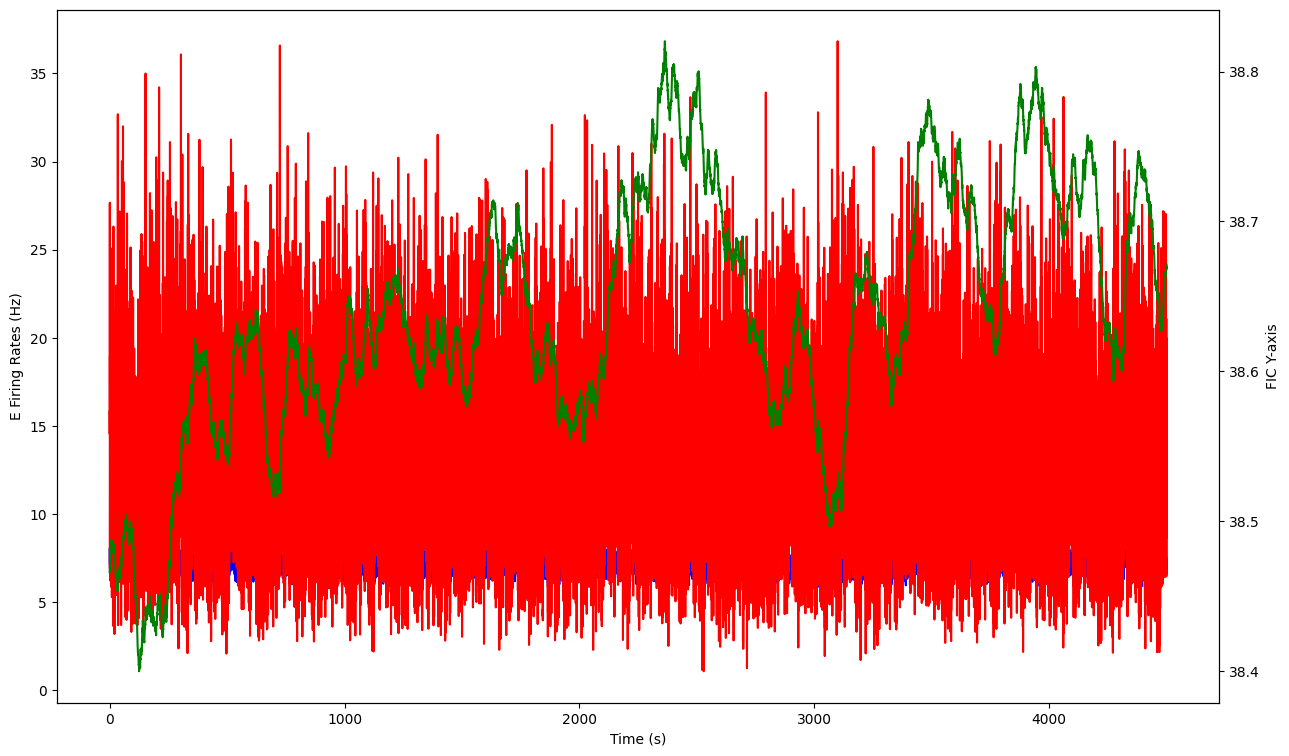

In [9]:
fig = plt.figure(figsize=(15, 9))
sel_t = np.arange(1, rates.shape[1] + 1)
sel_t_bold = np.arange(1, bold.shape[1] + 1)
plt.plot(sel_t * 0.1, np.mean(rates_inh, axis=0), 'b')
plt.plot(sel_t * 0.1, np.mean(rates, axis=0), 'r')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t * 0.1, np.mean(fic_t, axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')

ValueError: operands could not be broadcast together with shapes (8000,8000) (100,100) 

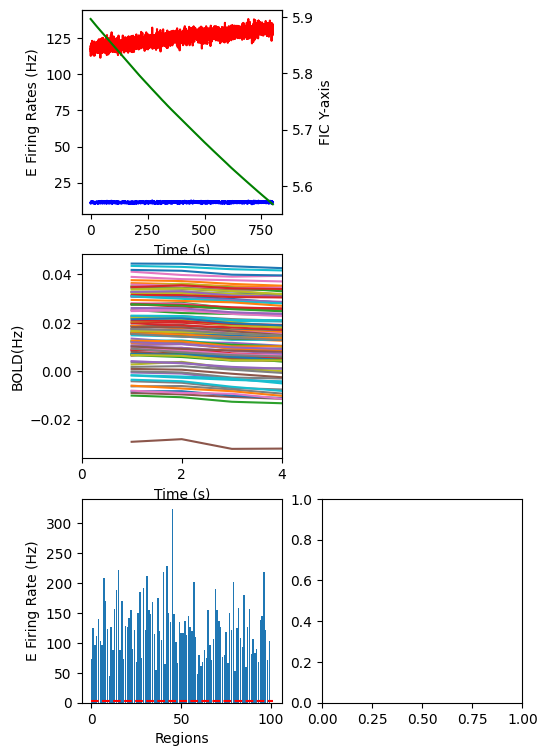

In [17]:
fig = plt.figure(figsize=(15, 9))
plt.subplot(3, 5, 1)
plt.plot(sel_t * 0.1, np.mean(rates_inh, axis=0), 'b')
plt.plot(sel_t * 0.1, np.mean(rates, axis=0), 'r')
plt.xlabel('Time (s)')
plt.ylabel('E Firing Rates (Hz)')
plt.twinx()
plt.plot(sel_t * 0.1, np.mean(fic_t, axis=0), color=[0, 0.5, 0])
plt.ylabel('FIC Y-axis')

plt.subplot(3, 5, 6)
plt.plot(sel_t_bold, filt_bold)
plt.xticks((sel_t_bold - 1) * params['TR'])
plt.xlim([0, sel_t_bold[-1]])
plt.xlabel('Time (s)')
plt.ylabel('BOLD(Hz)')

plt.subplot(3, 5, 11)
plt.bar(np.arange(N), np.mean(rates, axis=1), edgecolor='none')
plt.plot([0, N + 1], [params['obj_rate'], params['obj_rate']], 'r--')
plt.ylabel('E Firing Rate (Hz)')
plt.xlabel('Regions')

plt.subplot(3, 5, 12)
plt.imshow(rates_fc - np.eye(N))
plt.axis('square')
plt.title('FC Rates')
plt.colorbar()

plt.subplot(3, 5, 13)
# Assuming 'bold_fc' is defined
plt.imshow(bold_fc - np.eye(N))
plt.axis('square')
plt.title('FC BOLD')
plt.colorbar()

plt.subplot(3, 5, 14)
plt.plot(np.zscore(C.flatten()), np.zscore(rates_fc.flatten()), 'k.')
plt.plot(np.zscore(C.flatten()), np.zscore(bold_fc.flatten()), 'r.')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(['FC Rates', 'FC BOLD'])
plt.xlabel('SC_{i,j}(zscore)')
plt.ylabel('FC_{i,j} (zscore)')

plt.subplot(3, 5, 15)
plt.imshow(fcd)
plt.axis('square')
plt.title('FCD')
plt.colorbar()

plt.tight_layout()
plt.show()

IndexError: index 8000 is out of bounds for axis 1 with size 8000

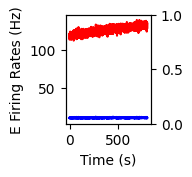